<a href="https://colab.research.google.com/github/tranrobin/CustomerReturns/blob/main/CustomerReturns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
attorney = pd.read_csv("attorneys.csv")
to_drop = ['Id',
           'StateName']
attorney.drop(to_drop, inplace=True, axis=1)

In [ ]:
client = pd.read_csv("clients.csv")
to_drop = ["Id",
           "StateName"]
client.drop(to_drop, inplace=True, axis=1)

In [ ]:
question = pd.read_csv("questions.csv")
question.drop("Id", inplace=True, axis=1)

In [ ]:
client.rename(columns = {'StateAbbr':'Client_state', 'ClientUno':'Client_ID',
                         'County':'Client_county','StateName':'Client_stateName',
                         'PostalCode':'Client_postalCode'}, inplace = True)
attorney.rename(columns = {'StateAbbr':'Attorney_state', 'AttorneyUno':'Attorney_ID',
                           'City':'Attorney_city', 'County':'Attorney_county',
                           'StateName':'Attorney_stateName','PostalCode':'Attorney_postalCode'}, inplace = True)

# Create train & Data Cleaning

Create train table

In [ ]:
client_question = pd.merge(client, question, left_on='Client_ID', right_on='AskedByClientUno')
train = pd.merge(client_question, attorney, left_on='TakenByAttorneyUno', right_on='Attorney_ID')

In [ ]:
df_counts = train.groupby('AskedByClientUno').size().reset_index(name='NumberOfVisits')
# add Repeat column to original dataframe
df = train.merge(df_counts, on='AskedByClientUno')
train['Repeat'] = (df['NumberOfVisits'] > 1).astype(int)

In [ ]:
# replace repetitive values
train = train.replace(['I\'d rather not answer', 'Other', 'Non-Conforming', 'Female,Non-Conforming', 'Female,Male',
                       'Non-Conforming,Other', 'Female,Other', 'Male,Non-Conforming', 'Female,Male,Non-Conforming,Other'], 'Other')
train = train.replace(['Married / remarried'], 'Married')
train = train.replace(['Divorced or Widowed', 'Separated', 'Divorced', 'Widowed'], 'Separated/Divorced/Widowed')

In [ ]:
to_drop = ["Client_postalCode", "Client_county", "Client_ID", "EthnicIdentity",
           "Attorney_ID", "Attorney_postalCode", "Attorney_county", "Attorney_city", "StateAbbr",
           "InvestmentsBalance", "SavingsBalance", "AllowedIncome",
           "QuestionUno", "Subcategory", "CategoryUno", "SubcategoryUno", "AskedByClientUno", "TakenByAttorneyUno", "ClosedByAttorneyUno",
           "AskedOnUtc", "TakenOnUtc", "ClosedOnUtc", "CreatedUtc_x", "CreatedUtc_y", "LegalDeadline"]
train.drop(to_drop, inplace=True, axis=1)

Fill null values & Eliminate outliers

In [ ]:
# fill null values
train.fillna(np.nan, inplace=True)
columns = list(train.columns)

for col in columns:
  if train[col].dtype in [np.float64, np.int64]:
    random_value = np.random.choice(train[col].dropna())
  else:
    value_counts = train[col].value_counts(normalize=True)
    random_value = np.random.choice(value_counts.index, p=value_counts.values)
  train[col].fillna(random_value, inplace=True)

In [ ]:
# change Repeat type from int to float
train['Repeat'] = train['Repeat'].astype(float)

In [ ]:
# eliminate outliers
for col in train.columns:
  if train[col].dtype in [np.float64, np.int64]:
    mean = train[col].mean()
    std = train[col].std()
    upper_bound = mean + 3*std
    lower_bound = mean - 3*std
    train = train[(train[col] > lower_bound) & (train[col] < upper_bound)]

# EDA & Visualization


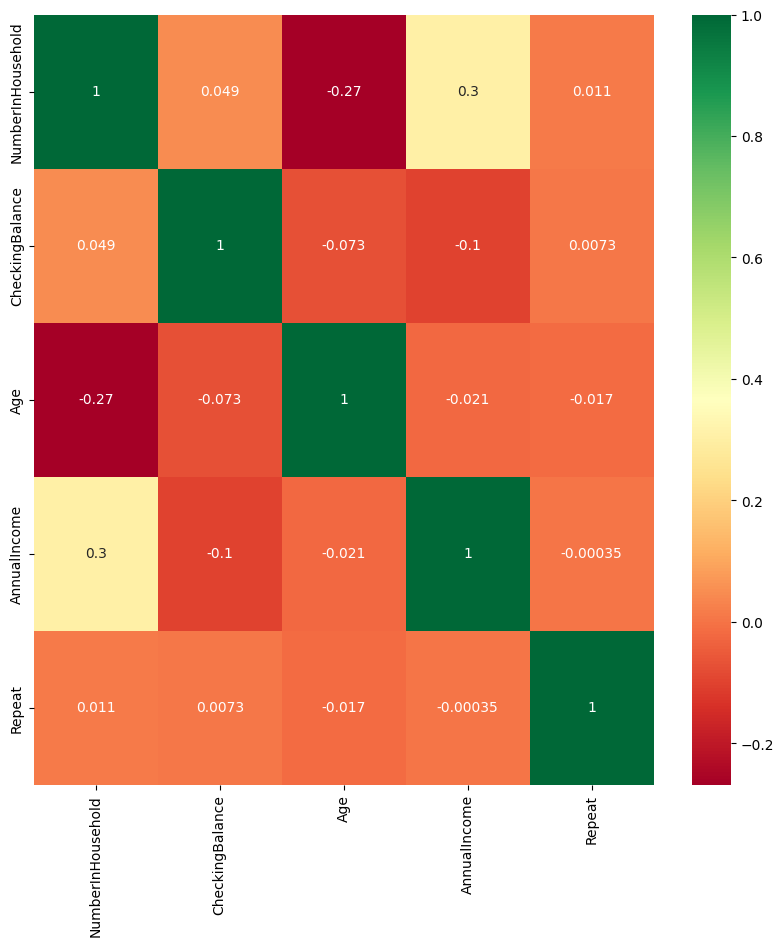

In [ ]:
features = ['NumberInHousehold', 'Veteran', 'Client_state', 'Category',
                     'Attorney_state', 'MaritalStatus', 'Gender', 'CheckingBalance', 'Imprisoned', 'Age', 'AnnualIncome', 'Repeat']
X = train[features]

plt.subplots(figsize=(10, 10))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")
plt.show()

# Label Encoder

In [ ]:
#convert categorical variables
labelencoder = LabelEncoder()
train['MaritalStatus'] = labelencoder.fit_transform(train['MaritalStatus'])
train['Gender'] = labelencoder.fit_transform(train['Gender'])
train['Imprisoned'] = labelencoder.fit_transform(train['Imprisoned'])
train['Veteran'] = labelencoder.fit_transform(train['Veteran'])
train['Client_state'] = labelencoder.fit_transform(train['Veteran'])
train['Attorney_state'] = labelencoder.fit_transform(train['Veteran'])
train['Category'] = labelencoder.fit_transform(train['Veteran'])

# Feature Elimination

*Recursive* Feature Elimination

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

# separate the target variable from the feature variables
y = train['Repeat']
X = train.drop('Repeat', axis=1)
# define estimator
estimator = DecisionTreeClassifier()
# define method
rfe = RFE(estimator=estimator, n_features_to_select=5)

# fit model
rfe.fit(X, y)
# transform data
X_rfe = rfe.transform(X)
# print selected features
print(X.columns[rfe.support_])

Index(['Age', 'MaritalStatus', 'NumberInHousehold', 'AnnualIncome',
       'CheckingBalance'],
      dtype='object')


Decision Tree Regressor

In [ ]:
target_variable = train[['Repeat']]
feature_columns = train.drop('Repeat', axis=1)

dtree = DecisionTreeRegressor()
dtree.fit(feature_columns, target_variable)

# Get the feature importances
importances = dtree.feature_importances_
# Get the indices of the top 5 features
top_indices = importances.argsort()[-5:]
# Get the names of the top 5 features
top_features = feature_columns.columns[top_indices]
print(top_features)

# Train the decision tree regressor using only the top 5 features
dtree_top = DecisionTreeRegressor()
dtree_top.fit(feature_columns[top_features], target_variable)
# Evaluate the model
predictions = dtree_top.predict(feature_columns[top_features])
mse = mean_squared_error(target_variable, predictions)
print(f"Mean squared error: {mse}")

Index(['MaritalStatus', 'NumberInHousehold', 'Age', 'CheckingBalance',
       'AnnualIncome'],
      dtype='object')
Mean squared error: 0.04390159478522999


# Oversampling & Data Splitting

In [ ]:
X = train[['Age', 'MaritalStatus', 'NumberInHousehold',
           'AnnualIncome', 'CheckingBalance']]
y = train['Repeat']

In [ ]:
# to see if data is imbalance
train['Repeat'].value_counts()
# data is highly imbalance

0.0    113041
1.0     27540
Name: Repeat, dtype: int64

In [ ]:
# balance data
from pandas.core.common import random_state
from imblearn.combine import SMOTEENN
smtn = SMOTEENN(random_state = 0)
# train model
smtn.fit(X, y)
# make samples
X, y = smtn.fit_resample(X, y)
y.value_counts()

1.0    58801
0.0    44162
Name: Repeat, dtype: int64

In [ ]:
# split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Run Model

Logistics

In [ ]:
# import libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")

    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=200)
rf_clf.fit(X_train, y_train)

print_score(rf_clf, X_train, y_train, X_test, y_test, train=True)
print_score(rf_clf, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 99.97%
_______________________________________________
CLASSIFICATION REPORT:
                    0.0           1.0  accuracy     macro avg  weighted avg
precision      0.999237      1.000000  0.999672      0.999618      0.999672
recall         1.000000      0.999426  0.999672      0.999713      0.999672
f1-score       0.999618      0.999713  0.999672      0.999666      0.999672
support    35345.000000  47025.000000  0.999672  82370.000000  82370.000000
_______________________________________________
Confusion Matrix: 
 [[35345     0]
 [   27 46998]]

Test Result:
Accuracy Score: 89.20%
_______________________________________________
CLASSIFICATION REPORT:
                   0.0           1.0  accuracy     macro avg  weighted avg
precision     0.845003      0.932687  0.892002      0.888845      0.895145
recall        0.915731      0.874236  0.892002      0.894983      0.892002
f1-score      0.878946      0.902516  0.892002      0.890731      0.892424
suppo

KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1, weights='distance',algorithm='kd_tree',n_jobs=-1)
knn.fit(X_train,y_train)
y_predknn = knn.predict(X_test)

print_score(knn, X_train, y_train, X_test, y_test, train=True)
print_score(knn, X_train, y_train, X_test, y_test, train=False)

Train Result:
Accuracy Score: 99.93%
_______________________________________________
CLASSIFICATION REPORT:
                    0.0           1.0  accuracy     macro avg  weighted avg
precision      0.999547      0.999171  0.999332      0.999359      0.999332
recall         0.998897      0.999660  0.999332      0.999278      0.999332
f1-score       0.999222      0.999415  0.999332      0.999319      0.999332
support    35345.000000  47025.000000  0.999332  82370.000000  82370.000000
_______________________________________________
Confusion Matrix: 
 [[35306    39]
 [   16 47009]]

Test Result:
Accuracy Score: 97.09%
_______________________________________________
CLASSIFICATION REPORT:
                   0.0           1.0  accuracy     macro avg  weighted avg
precision     0.972951      0.969425  0.970912      0.971188      0.970935
recall        0.958716      0.980044  0.970912      0.969380      0.970912
f1-score      0.965781      0.974705  0.970912      0.970243      0.970884
suppo